### Load data ###

In [12]:
import pickle

with open('NBA_temporal_dataset.pkl', 'rb') as file:
    temporal_data_dict = pickle.load(file)

X_primary = temporal_data_dict['X_primary']
X_opposing = temporal_data_dict['X_opposing'] 
y = temporal_data_dict['y']

print(X_primary.shape)
print(X_opposing.shape)
print(y.shape)

(83178, 5, 42)
(83178, 5, 42)
(83178, 1)


### Reshape data so that each sample is 2D array ###

In [13]:
import numpy as np

X_primary = X_primary.reshape(X_primary.shape[0], -1)
X_opposing = X_opposing.reshape(X_opposing.shape[0], -1)

X = np.concatenate((X_primary, X_opposing), axis=1)
print(X.shape)
print(y.shape)

(83178, 420)
(83178, 1)


In [14]:
import torch

X_torch = torch.from_numpy(X).float()
y_torch = torch.from_numpy(y).float()

In [15]:
from torch.utils.data import Dataset, DataLoader

class NBADataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __len__(self):
        return len(self.X_data)

    def __getitem__(self, idx):
        return self.X_data[idx], self.y_data[idx]

In [16]:
from torch.utils.data import random_split

dataset = NBADataset(X_torch, y_torch)

train_size = int(0.75 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 1024

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

### Load model ###

## Create FFN module ##

In [17]:
# import torch.nn as nn

# # class FFN(nn.Module):
# #     def __init__(self, input_size):
# #         super(FFN, self).__init__()
# #         self.fc_home = nn.Linear(input_size//2)
# #         self.fc_away = nn.Linear(input_size//2)
# #         self.relu = nn.ReLU()
# #         self.fc2 = nn.Linear(hidden_size*2 + 1)
# #         self.fc3 = nn.Linear(hidden_size, 1)
# #         self.sigmoid = nn.Sigmoid()



# #     def forward(self, x):
# #         x_home = self.fc_home(x[:,0:11])
# #         x_away = self.fc_away(x[:,11:22])

# #         x = torch.cat((x_home, x_away, x[:,22:]), dim=1)
# #         x = self.relu(self.fc2(x))
# #         x = self.sigmoid(self.fc3(x))
# #         return x

# class FFN(nn.Module):
#     def __init__(self, input_size):
#         super(FFN, self).__init__()
#         self.fc1 = nn.Linear(input_size, 128)
#         self.fc2 = nn.Linear(128, 256)
#         self.fc3 = nn.Linear(256, 64)
#         self.output = nn.Linear(64, 1)
#         self.relu = nn.ReLU()




#     def forward(self, x):
#         x = self.relu(self.fc1(x))
#         x = self.relu(self.fc2(x))
#         x = self.relu(self.fc3(x))
#         x = self.output(x)
#         return x
        



In [18]:
import torch.nn as nn

class FFN(nn.Module): 
    def __init__(self, input_size=420):
        super(FFN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 512),  # Increase to 512 neurons
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            
            nn.Linear(128, 1)
            )


    def forward(self, x):
        return self.model(x)



In [19]:
# Function to train and test model 
import time


def AccuracyAndLossOverEpoch(model, train_loader, test_loader, optimizer, criterion, device, epochs):
    train_losses = []
    train_accuracies = []
    test_accuracies = []
    
    time_to_train_per_epoch_list = []

    model.to(device)

    for epoch in range(epochs):
        # Set current epoch train loss, train accuracy and test accuracy to 0.0
        train_loss = 0.0
        train_acc = 0.0
        test_acc = 0.0
        time_per_epoch = 0.0
        # Put model in training mode
        model.train()
        start_time = time.time()
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            # Get loss on current batch
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            # Accumulate train loss in epoch
            train_loss += loss.item()
        # Add train loss to train_losses, in order to track
        # print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader)}")
        train_losses.append(train_loss)
        end_time = time.time()
        
        # Calculate time per epoch and accumulate
        time_per_epoch = end_time - start_time
        time_to_train_per_epoch_list.append(time_per_epoch)
        
        # Put model in evaluation mode
        model.eval()
        correct = 0.0
        total = 0.0
        with torch.no_grad():
            # Iterate over train dataset, in order to get accuracy for model at current epoch
            for X_batch, y_batch in train_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                y_pred = model(X_batch)
                y_pred = nn.Sigmoid()(y_pred)
                y_pred = (y_pred >= 0.5).float().round()
                correct += (y_pred == y_batch).sum().item()
                total += len(y_batch)
        # Add train accuracy to train_accuracies
        train_acc = correct / total
        print(f"Epoch {epoch+1}, Training Accuracy: {train_acc}")
        train_accuracies.append(train_acc)

        # Put model in evaluation mode
        model.eval()
        correct = 0.0
        total = 0.0
        with torch.no_grad():
            # Iterate over test dataset, in order to get accuracy for model at current epoch
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                y_pred = model(X_batch)
                y_pred = nn.Sigmoid()(y_pred)
                y_pred = (y_pred >= 0.5).float()
                # print(y_pred)
                # print(y_batch)
                correct += (y_pred == y_batch).sum().item()
                total += len(y_batch)
        # Add test accuracy to test_accuracies
        test_acc = correct / total
        print(f"Epoch {epoch+1}, Test Accuracy: {test_acc}")
        test_accuracies.append(test_acc)

    return train_losses, train_accuracies, test_accuracies, time_to_train_per_epoch_list

In [20]:
# initialize model, optimizer and loss function

model = FFN(input_size=X.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = nn.BCEWithLogitsLoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [21]:
# Train and test model 
train_losses, train_accuracies, test_accuracies, time_to_train_per_epoch_list = AccuracyAndLossOverEpoch(model, train_loader, test_loader, optimizer, criterion, device, epochs = 100)

Epoch 1, Training Accuracy: 0.5783466649567991
Epoch 1, Test Accuracy: 0.5715797066602548
Epoch 2, Training Accuracy: 0.600419986214193
Epoch 2, Test Accuracy: 0.5882664101947583
Epoch 3, Training Accuracy: 0.6098296010130965
Epoch 3, Test Accuracy: 0.6005770617937004
Epoch 4, Training Accuracy: 0.6136126829424683
Epoch 4, Test Accuracy: 0.6000961769656168
Epoch 5, Training Accuracy: 0.6191109757465977
Epoch 5, Test Accuracy: 0.6050492906948786
Epoch 6, Training Accuracy: 0.6201048362534665
Epoch 6, Test Accuracy: 0.6050492906948786
Epoch 7, Training Accuracy: 0.6216276870301204
Epoch 7, Test Accuracy: 0.6065881221447463
Epoch 8, Training Accuracy: 0.6218841671609252
Epoch 8, Test Accuracy: 0.608367396008656
Epoch 9, Training Accuracy: 0.6230543577577224
Epoch 9, Test Accuracy: 0.6090406347679731
Epoch 10, Training Accuracy: 0.6248817786897072
Epoch 10, Test Accuracy: 0.607597980283722
Epoch 11, Training Accuracy: 0.6258916692047513
Epoch 11, Test Accuracy: 0.6079826881461889
Epoch 12,

Total time to train model: 118.75636386871338
Number of epochs:  100
Average time per epoch:  1.1875636386871338


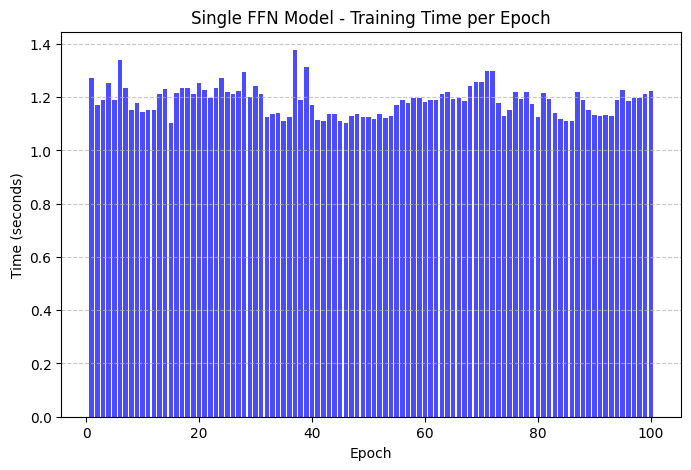

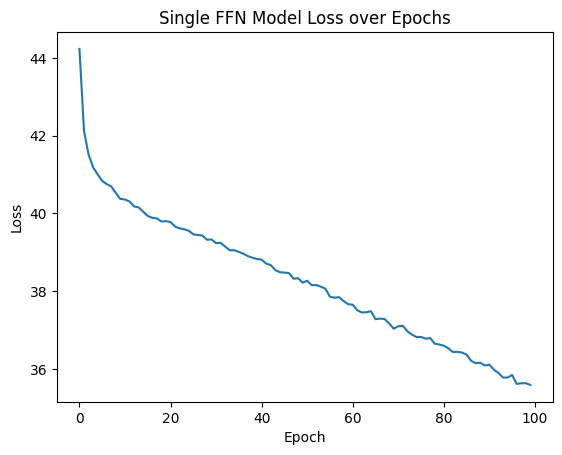

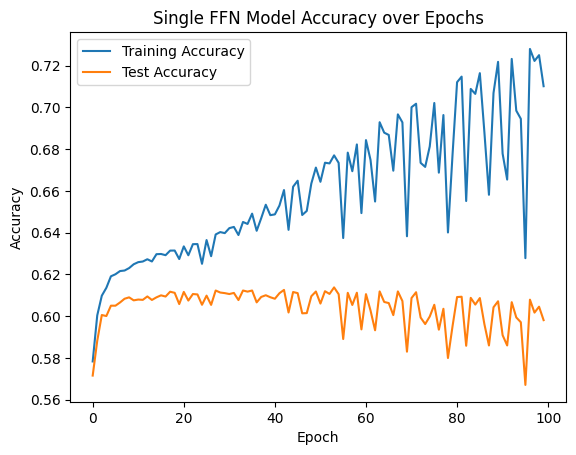

In [22]:
import matplotlib.pyplot as plt

def plot_time_loss_train_test_accuracies(train_accuracies, test_accuracies, time_to_train_per_epoch_list, model_name):

    print(f"Total time to train model: {sum(time_to_train_per_epoch_list)}")

    print("Number of epochs: ", len(time_to_train_per_epoch_list))

    print("Average time per epoch: ", sum(time_to_train_per_epoch_list) / len(time_to_train_per_epoch_list))

    epochs = list(range(1, len(time_to_train_per_epoch_list) + 1))  # Epoch numbers

    plt.figure(figsize=(8, 5))
    plt.bar(epochs, time_to_train_per_epoch_list, color='blue', alpha=0.7)
    plt.xlabel("Epoch")
    plt.ylabel("Time (seconds)")
    plt.title(f"{model_name} - Training Time per Epoch")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    plt.plot(train_losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(model_name + " Loss over Epochs")
    plt.show()

    plt.plot(train_accuracies, label="Training Accuracy")
    plt.plot(test_accuracies, label="Test Accuracy")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(model_name + " Accuracy over Epochs")
    plt.show()

plot_time_loss_train_test_accuracies(train_accuracies, test_accuracies, time_to_train_per_epoch_list, "Single FFN Model")

In [23]:
# Function for evaluating model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_ffn_classifier(model, test_dataset, model_name="FFN", batch_size=512):
    model.eval()
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    all_probs = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch).squeeze()
            probs = torch.sigmoid(logits)

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend((probs >= 0.5).int().cpu().numpy())
            all_labels.extend(y_batch.int().cpu().numpy())

    # Calculate metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_probs)
    cm = confusion_matrix(all_labels, all_preds)

    # Print metrics
    print(f"\nEvaluation for {model_name}")
    print(f"Accuracy     : {acc:.4f}")
    print(f"Precision    : {prec:.4f}")
    print(f"Recall       : {rec:.4f}")
    print(f"F1 Score     : {f1:.4f}")
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    print("\nClassification Report:\n", classification_report(all_labels, all_preds))

    # Plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

def plot_prediction_distribution_ffn(model, test_dataset, model_name="FFN", batch_size=512):
    model.eval()
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    all_probs = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            logits = model(X_batch).squeeze()
            probs = torch.sigmoid(logits)
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels).ravel()

    true_win_probs = all_probs[all_labels == 1]
    true_loss_probs = all_probs[all_labels == 0]

    plt.figure(figsize=(8, 5))
    sns.histplot(true_win_probs, color="green", label="True Wins", kde=True, stat="density", bins=30)
    sns.histplot(true_loss_probs, color="red", label="True Losses", kde=True, stat="density", bins=30)

    plt.title(f"{model_name} – Probability Distribution of Predicted Wins")
    plt.xlabel("Predicted Probability of Win")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_roc_curve_ffn(model, test_dataset, model_name="FFN", batch_size=512):
    model.eval()
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    all_probs = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            logits = model(X_batch).squeeze()
            probs = torch.sigmoid(logits)  # convert logits to probabilities
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve – {model_name}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()




Evaluation for Single FFN
Accuracy     : 0.5981
Precision    : 0.6392
Recall       : 0.4534
F1 Score     : 0.5305
ROC-AUC Score: 0.6404

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.74      0.65     10382
           1       0.64      0.45      0.53     10413

    accuracy                           0.60     20795
   macro avg       0.61      0.60      0.59     20795
weighted avg       0.61      0.60      0.59     20795



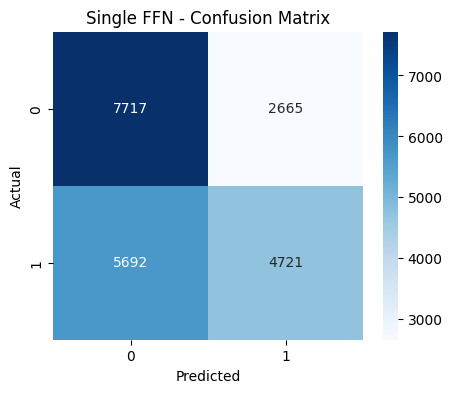

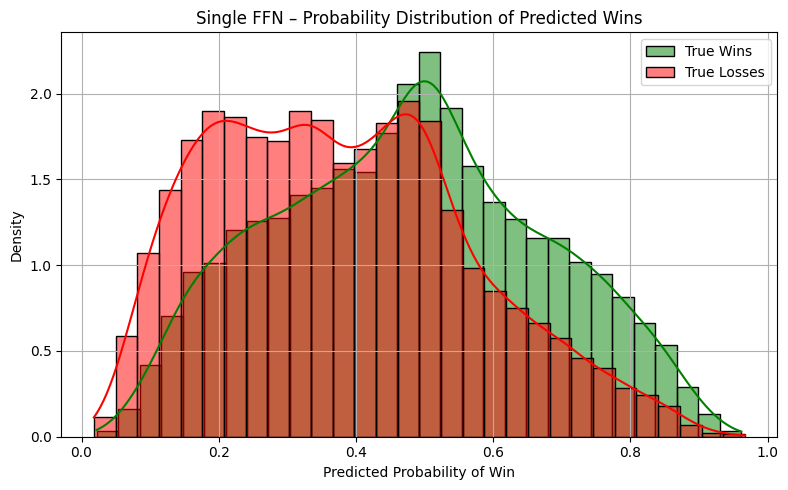

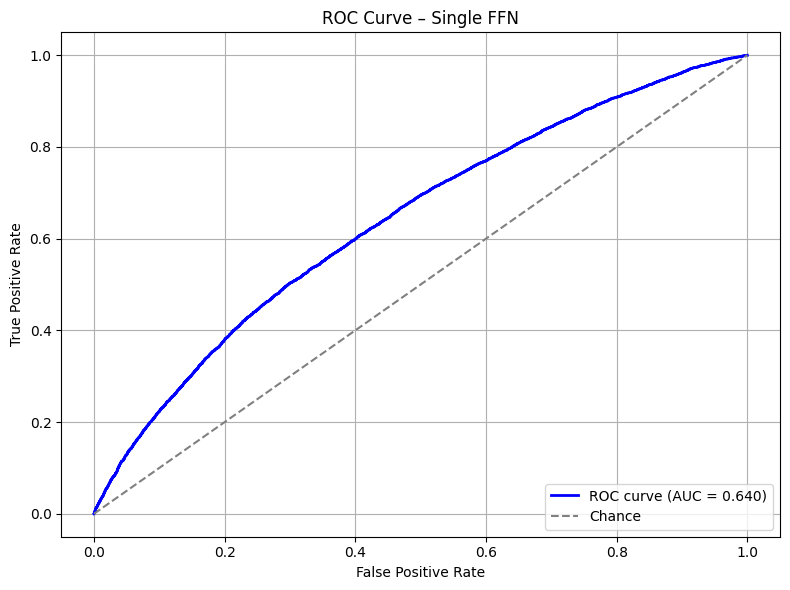

In [24]:
evaluate_ffn_classifier(model, test_dataset, model_name="Single FFN")
plot_prediction_distribution_ffn(model, test_dataset, model_name="Single FFN")
plot_roc_curve_ffn(model, test_dataset, model_name="Single FFN")

### Save the model ###

In [25]:
import os

# Create the directory if it doesn't exist
os.makedirs('models', exist_ok=True)

path = os.path.join('.', 'models', 'single_ffn_model.pth')

# Save the model's state_dict
torch.save(model.state_dict(), path)


### Load model ###

In [26]:
import os
import torch

# Load the model's state_dict

model = FFN(input_size=420)
path = os.path.join('.', 'models', 'single_ffn_model.pth')
model.load_state_dict(torch.load(path))
model.eval()

C:\Users\Alex1\AppData\Local\Temp\ipykernel_87008\3074447171.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


FFN(
  (model): Sequential(
    (0): Linear(in_features=420, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [27]:
print(train_accuracies)
print(test_accuracies)
print(time_to_train_per_epoch_list)

[0.5783466649567991, 0.600419986214193, 0.6098296010130965, 0.6136126829424683, 0.6191109757465977, 0.6201048362534665, 0.6216276870301204, 0.6218841671609252, 0.6230543577577224, 0.6248817786897072, 0.6258916692047513, 0.6261962393600821, 0.6272862799160027, 0.6262122693682574, 0.6297068111504737, 0.6298029911995255, 0.6292259109052145, 0.6314220220252312, 0.6314540820415818, 0.6273824599650546, 0.6334418030553196, 0.6291938508888639, 0.6344997835948897, 0.6345478736194156, 0.6250901687959861, 0.6364714746004521, 0.6287450106599555, 0.6391484859657278, 0.6402866165461745, 0.63978968629274, 0.6421781575108604, 0.6427552378051713, 0.6388759758267477, 0.6451276790151163, 0.6441819085327734, 0.649119151050767, 0.6409117868650113, 0.646955099947101, 0.653383133225398, 0.648381770674703, 0.6487664908709103, 0.6529984130291906, 0.6604203068143565, 0.6413606270939198, 0.6620072776237116, 0.664876649087091, 0.6484619207155795, 0.6504175817129667, 0.6635301284003655, 0.6711764422999855, 0.66436

In [28]:
import csv

def save_training_stats_to_csv(filename, train_acc, test_acc, train_loss, time_per_epoch):
    with open(filename, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["Epoch", "Train Accuracy", "Test Accuracy", "Train Loss", "Time per Epoch (s)"])

        for epoch in range(len(train_acc)):
            writer.writerow([
                epoch + 1,
                train_acc[epoch],
                test_acc[epoch],
                train_loss[epoch],
                time_per_epoch[epoch]
            ])


save_training_stats_to_csv(
    os.path.join('.', 'training_data' ,'single_ffn.csv'),
    train_accuracies,
    test_accuracies,
    train_losses,
    time_to_train_per_epoch_list
)